## 2P data preprocessing 

### Import modules

In [44]:
## import libraries 
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

### Define data path 

In [45]:
## define path variables 
DATA_PATH = "/Volumes/Projects/2P5XFAD/JarascopeData/1CLT/1CLT-Full/suite2p/plane0/" ## path to where the data is mounted; can also sys.argv[1]

### Load suite2P output data 

In [46]:
## load all data 
F = np.load(os.path.join(DATA_PATH, "F.npy"), allow_pickle=True)
Fneu = np.load(os.path.join(DATA_PATH, "Fneu.npy"), allow_pickle=True)
spks = np.load(os.path.join(DATA_PATH, "spks.npy"), allow_pickle=True)
stat = np.load(os.path.join(DATA_PATH, "stat.npy"), allow_pickle=True)
ops =  np.load(os.path.join(DATA_PATH, "ops.npy"), allow_pickle=True)
ops = ops.item() ## converts ops to a dictionary
iscell = np.load(os.path.join(DATA_PATH, "iscell.npy"), allow_pickle=True)

In [47]:
print(Fneu.shape, F.shape)

(372, 41823) (372, 41823)


### Select ROIs which are 1's and with prob >= 90% 

In [48]:
rois_to_select_indices = (iscell[:, 0] == 1) & (iscell[:, 1] >= 0.8)
iscell_select = iscell[rois_to_select_indices]

prob = iscell_select[:, 1]
min_prob = np.min(prob)
print(f"The minimum probability of the selected ROIs is {min_prob}")

## what are the roi numbers
roi_numbers = np.unique(iscell_select[:, 0])
print(f"The unique ROI numbers are {roi_numbers}. If more than 1, then ROI = 1 does not mean a cell")

The minimum probability of the selected ROIs is 0.8069687154406943
The unique ROI numbers are [1.]. If more than 1, then ROI = 1 does not mean a cell


In [49]:
## extract the traces of the selected cells
F_cells = F[rois_to_select_indices]
Fneu_cells = Fneu[rois_to_select_indices]

In [50]:
print(F_cells.shape, Fneu_cells.shape)

(72, 41823) (72, 41823)


### Neuropil correction

In [51]:
## need to look at F - Fneu to get the actual fluorescence signal
correction_scalar = 0.7 ## based on suite2p documentation
F_corrected = F_cells - correction_scalar * Fneu_cells

### Normalize signal: dF_F

In [52]:
## calculating delta_F over F
F_mean = np.mean(F_corrected, axis=1) ## not sure if this is correct 
print(F_mean.shape)
print(F_mean[:, np.newaxis].shape)
F_mean = F_mean[:, np.newaxis]

## calculate dF/F
dF_F = (F_corrected - F_mean) / F_mean

(72,)
(72, 1)


In [53]:
## define function to plot spikes
def plot_spikes(spks_cell):
    # np.random.seed(100)
    # someCells = np.random.choice(NUM_CELLS, 10) ## select 10 random cells
    someCells = np.arange(10)
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.flatten()

    for i in range(10):
        axes[i].plot(spks_cell[i])
        axes[i].set_title("Cell: " + str(someCells[i] + 1))

    plt.show()

### Plot some sample spikes to see if everything looks "visually" normal. 

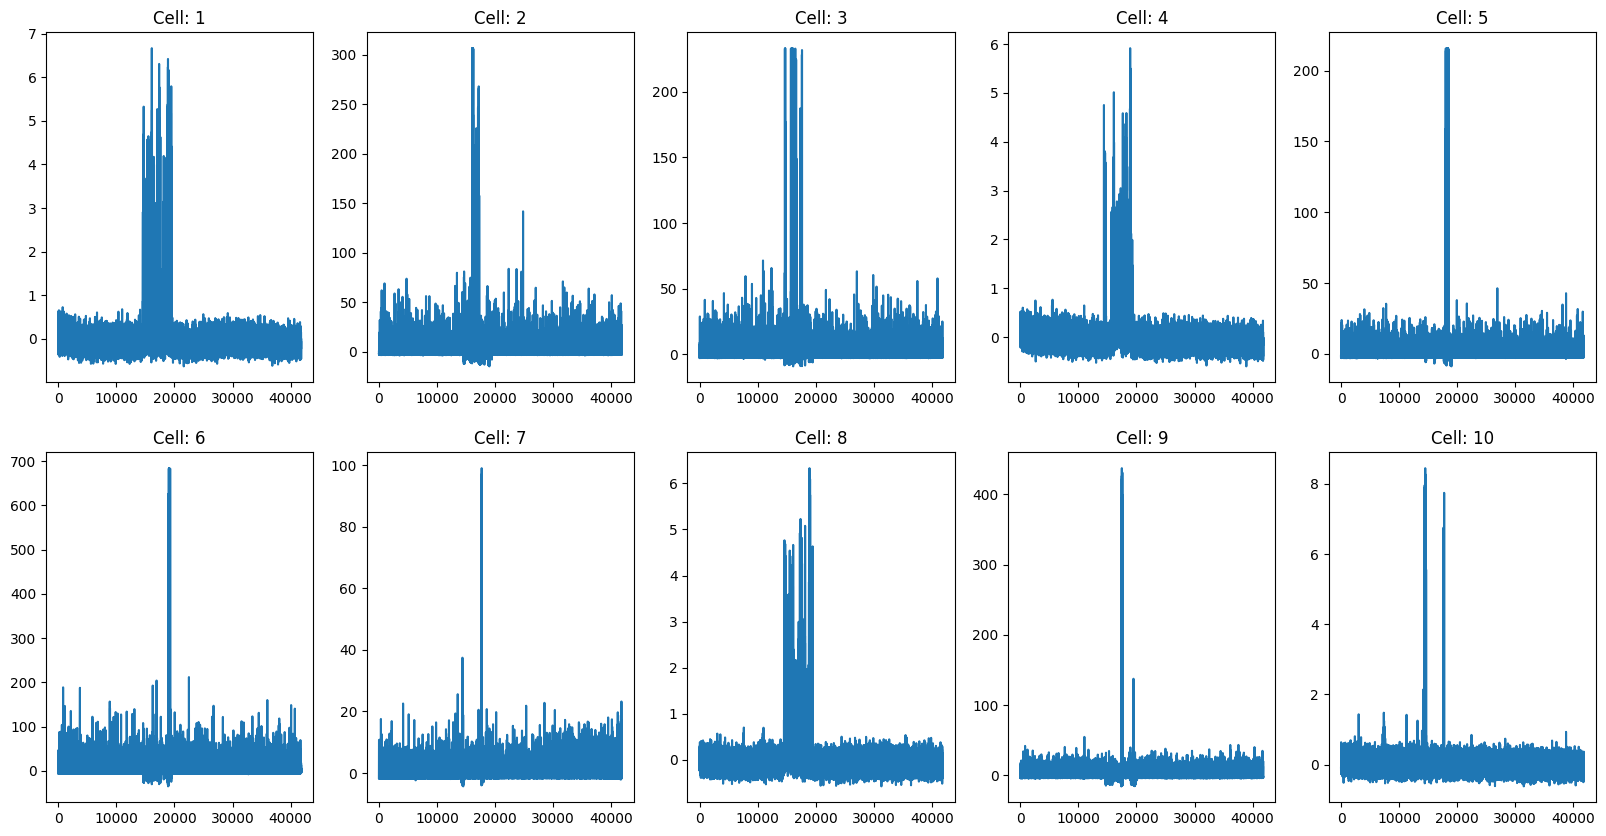

In [54]:
plot_spikes(dF_F)

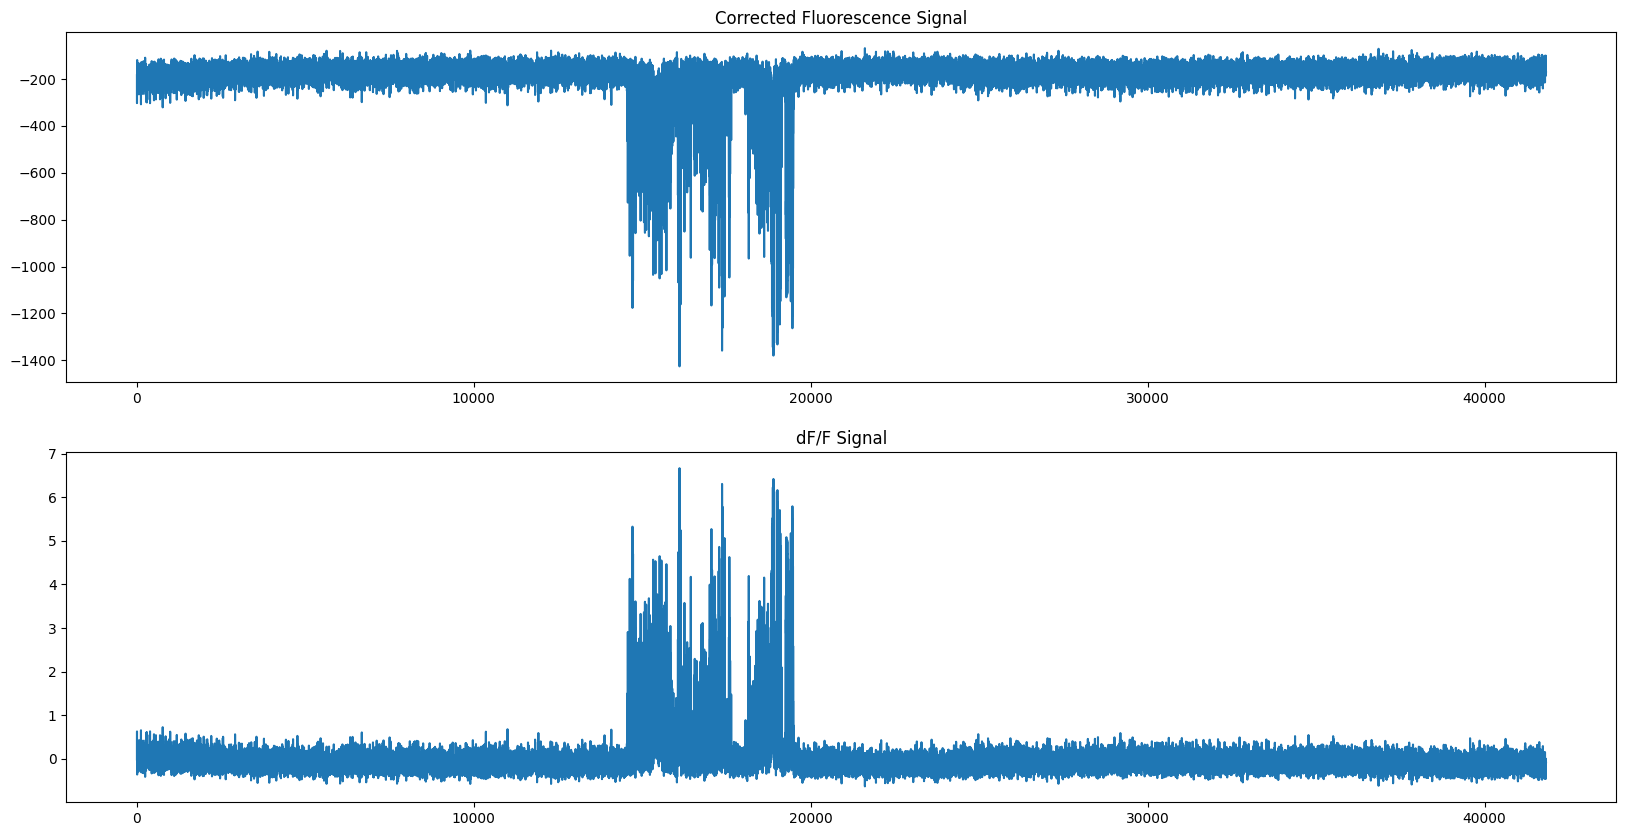

In [55]:
## plot traces of 1 cell to see how it looks 
def plot_traces(F_corrected_cell, dF_F_cell):
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))
    axes[0].plot(F_corrected_cell)
    axes[0].set_title("Corrected Fluorescence Signal")
    axes[1].plot(dF_F_cell)
    axes[1].set_title("dF/F Signal")

    plt.show()

plot_traces(F_corrected[0], dF_F[0]) ## for the first cell 

In [56]:
## plot the spiking of subset of cells
## define function to plot spikes
def plot_spikes_subset(spks_cell, time_points=50, cell_indices=None, y_lim=None):
    # np.random.seed(100)
    # someCells = np.random.choice(NUM_CELLS, 10) ## select 10 random cells
    if cell_indices is not None:
        cell_indices = np.array(list(cell_indices))
        for i in cell_indices:
            if i >= spks_cell.shape[0]:
                raise ValueError("Cell index out of range")
        someCells = np.array(cell_indices)
    else:
        someCells = np.array(list(np.arange(10)))
    
    num_rows = int(len(someCells) // np.sqrt(len(someCells)))
    num_cols = int(np.ceil(len(someCells) / num_rows))
    # print(num_rows, num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))  
    axes = axes.flatten()

    for i, cell_idx in enumerate(someCells):
        axes[i].plot(spks_cell[int(cell_idx), :time_points])
        axes[i].set_title("Cell: " + str(someCells[i] + 1))
        axes[i].set_xlabel("Time (s)")
        axes[i].set_ylabel("dF/F")
        if y_lim is not None:
            axes[i].set_ylim(y_lim)

    plt.tight_layout()
    plt.show()

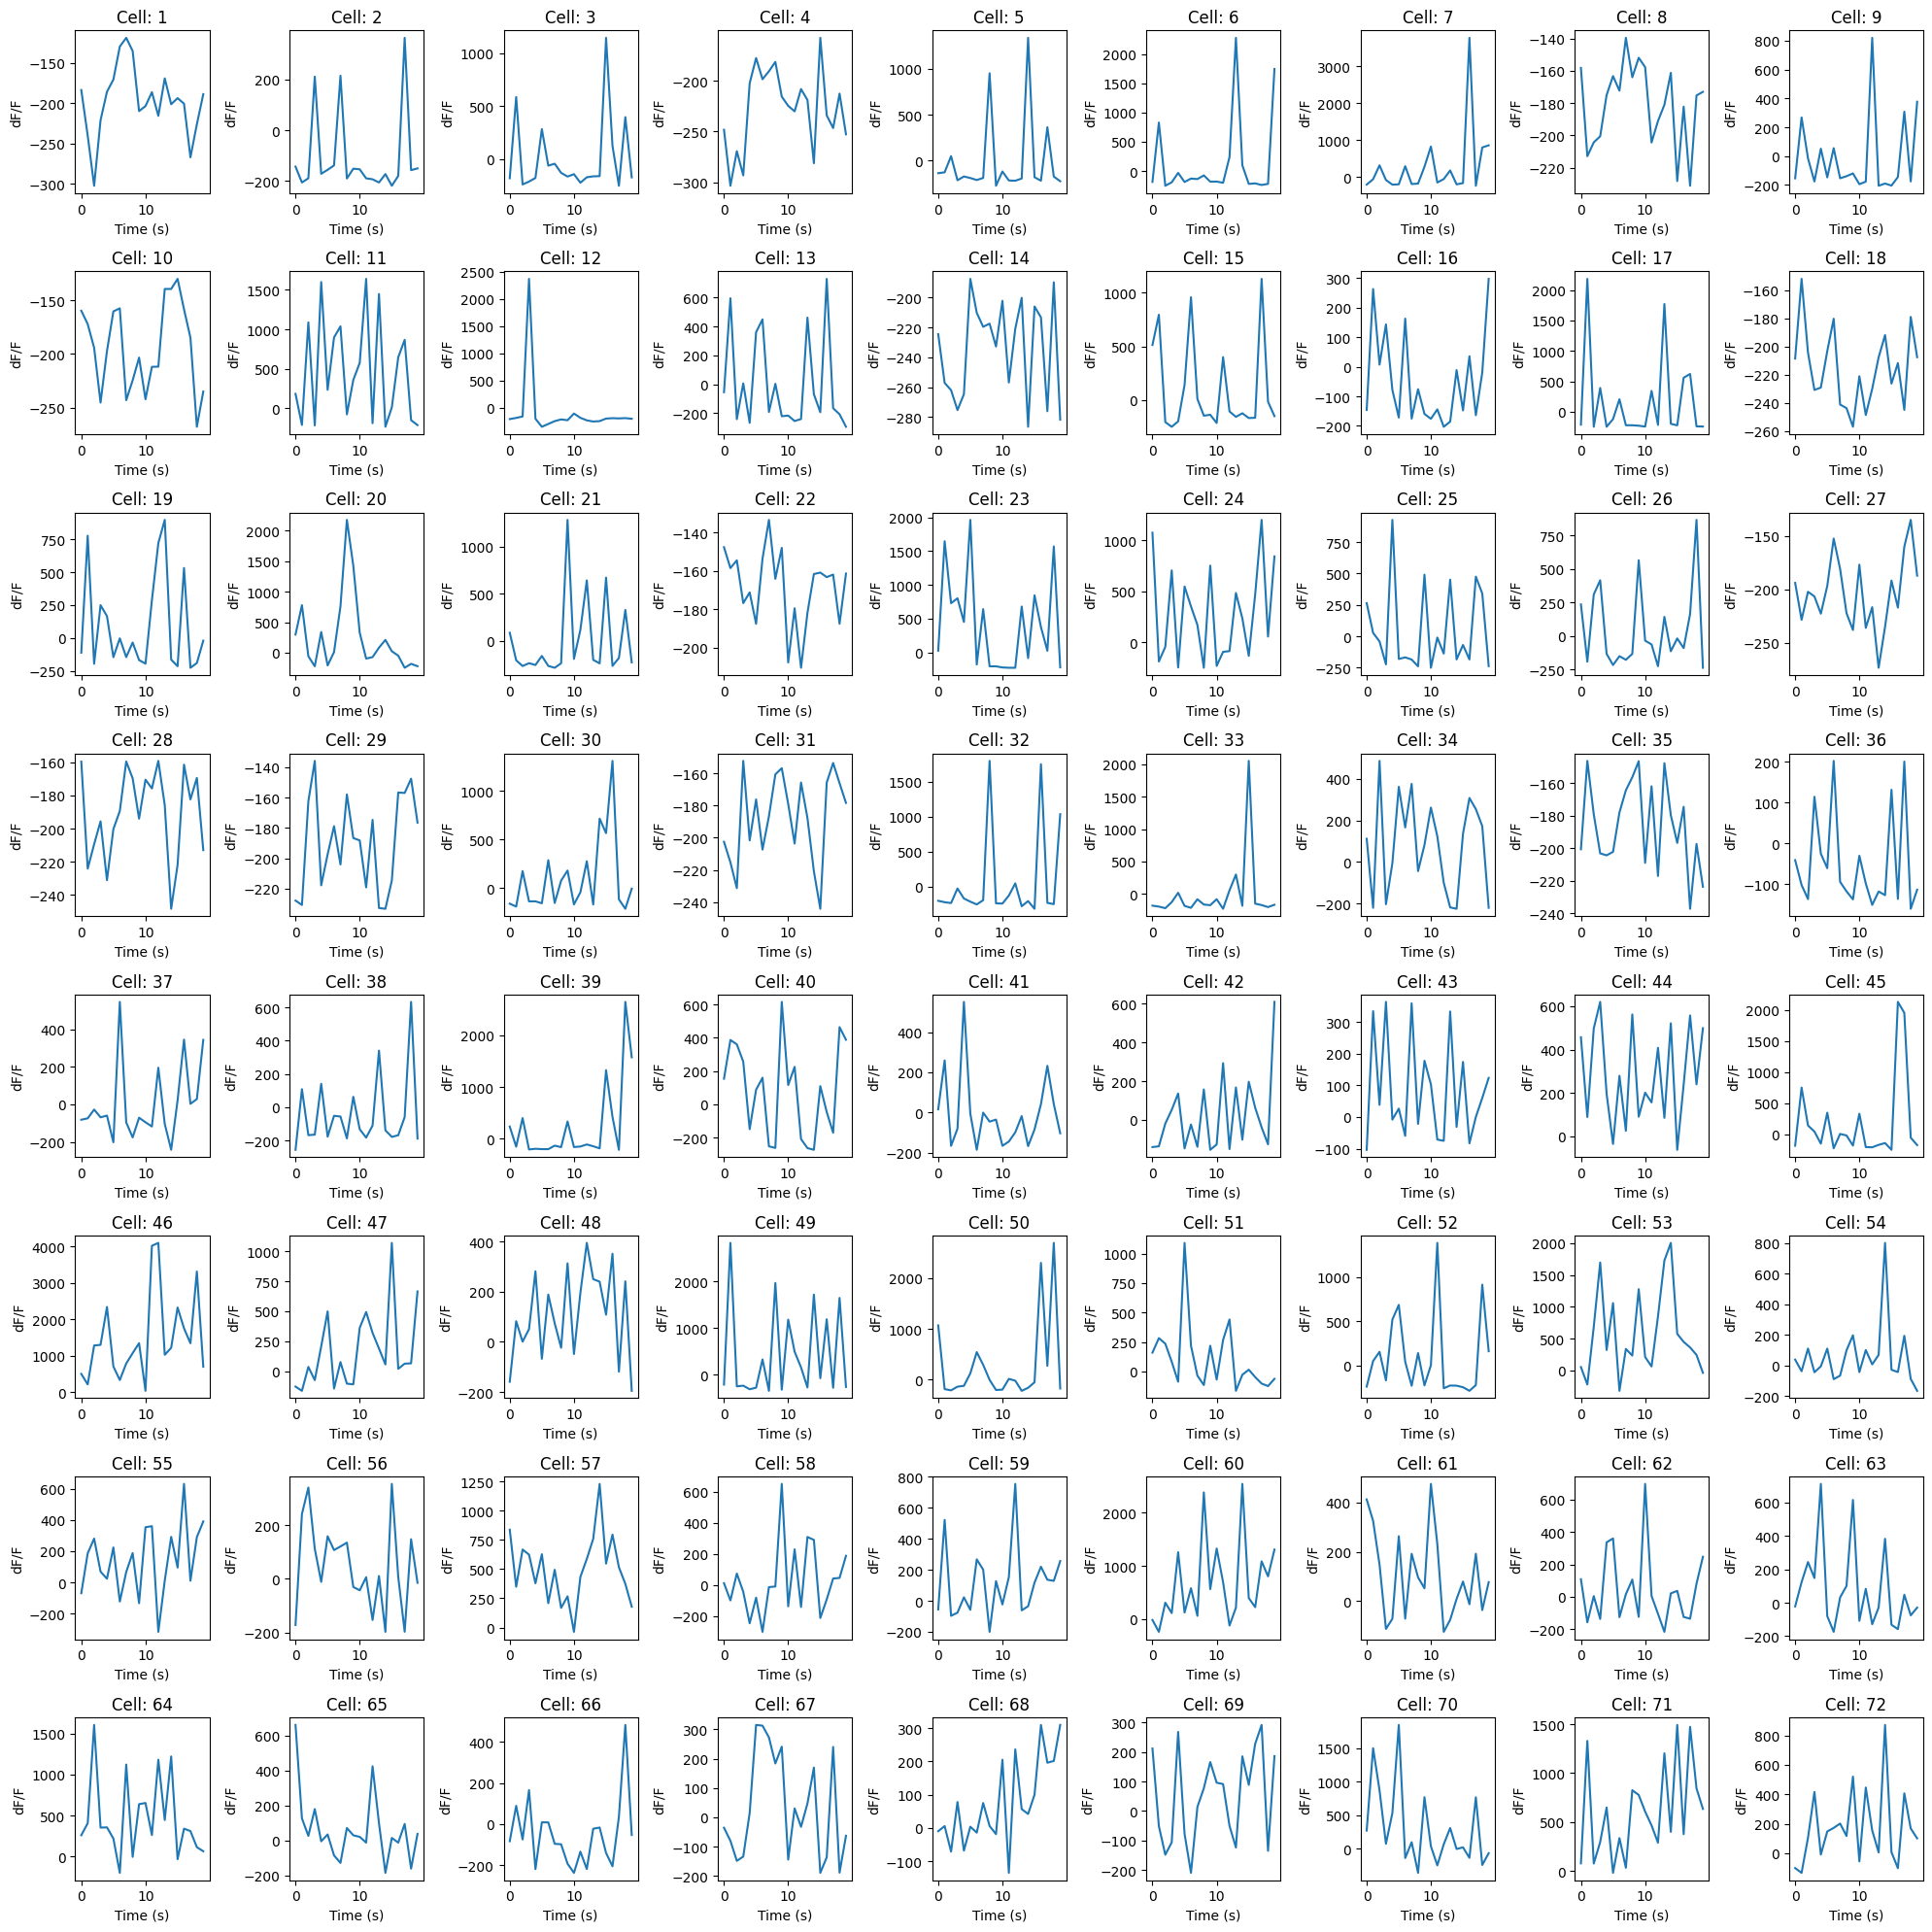

In [57]:
plot_spikes_subset(F_corrected, time_points=20, cell_indices=np.arange(F_corrected.shape[0]))

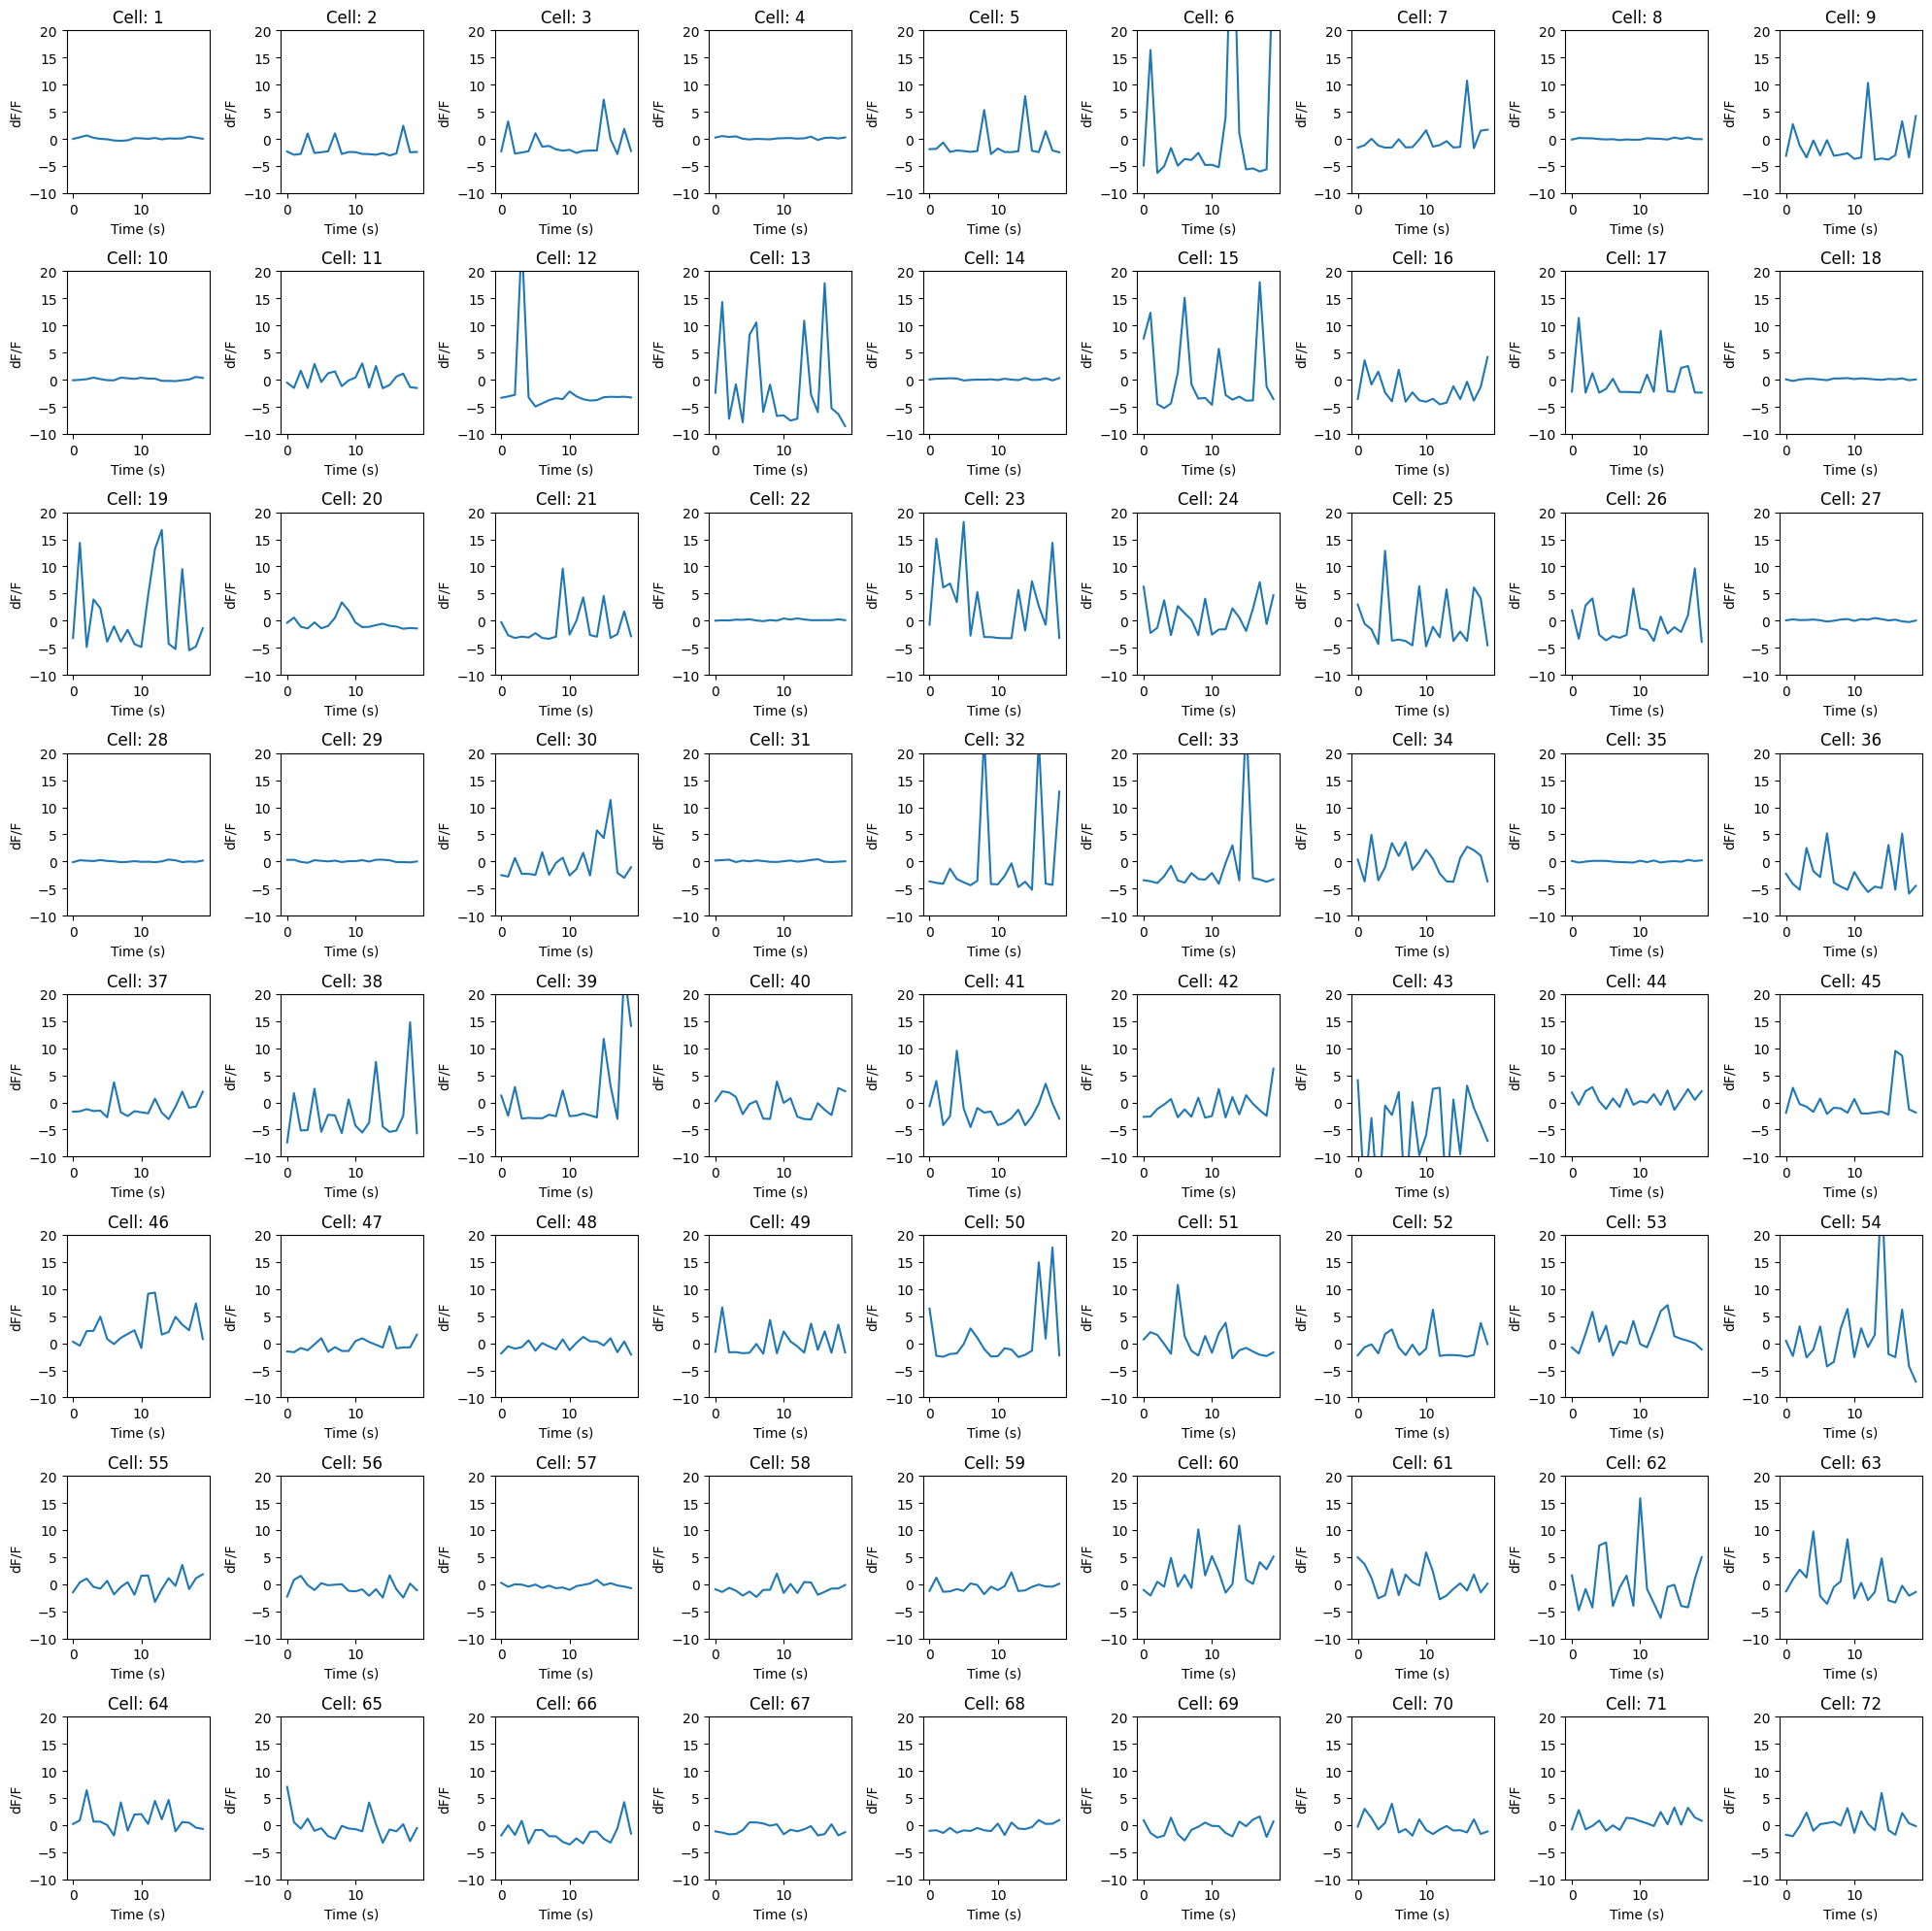

In [58]:
plot_spikes_subset(dF_F, time_points=20, cell_indices=np.arange(dF_F.shape[0]), y_lim=(-10, 20))

### Define global variables

In [59]:
## set global variables
NUM_CELLS = dF_F.shape[0]
NUM_POINTS = dF_F.shape[1]
FRAME_RATE = ops['fs']

print(NUM_CELLS, NUM_POINTS)

72 41823


### This block is implemented to remove any fluorescence traces which have 0 fluorescence for all time t. 

In [60]:
# ## remove all rows (cells) with zeros
# F_diff = F_diff[~np.all(F_diff == 0, axis=1)]
# F_diff.shape 

### Subset data according to the length of recording 

In [61]:
## define a function to subset the data 
def subset_data(data, num_points):
    num_cells = data.shape[0]
    data_subset = np.zeros((num_cells, num_points))

    for i in range(num_cells):
        data_subset[i] = data[i][:num_points]

    return data_subset

In [62]:
data_subset = {}

time_keys = [10, 15, 20, 30, 40, 45] ## this is in minutes 
print(type(time_keys[0]))
for time in time_keys:
    if time != 45:
        data_subset[time] = subset_data(dF_F, int(time*FRAME_RATE*60))
    else:
        data_subset[time] = dF_F 

## check the shape of the data
for time in data_subset.keys():
    print(f"The shape of the data for time {time} is {data_subset[time].shape}")

<class 'int'>
The shape of the data for time 10 is (72, 9294)
The shape of the data for time 15 is (72, 13941)
The shape of the data for time 20 is (72, 18588)
The shape of the data for time 30 is (72, 27882)
The shape of the data for time 40 is (72, 37176)
The shape of the data for time 45 is (72, 41823)


### Save data for further analyses

In [63]:
## save data for further processing 
DATA_PATH_SAVE = "/Users/praveslamichhane/Desktop/alzheimers/data/1CLT"
np.save(os.path.join(DATA_PATH_SAVE, "dF_F.npy"), dF_F)
np.save(os.path.join(DATA_PATH_SAVE, "data_subset.npy"), data_subset)